<a href="https://colab.research.google.com/github/hannahzafar/UMDAOSC650/blob/main/FinalProject_Zafar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, RepeatVector
import keras
from keras.src.preprocessing.sequence import TimeseriesGenerator

**Part A: Data Preprocessing**

In [263]:
# Import data saved to Github
# This dataset includes ~200 years of a "perpetual 2000" (consistently at year 2000 scenario) run from the model GEOS-S2S.
# Data is aggregated for NH polar region: SLP_N, SNO_N, TS_N = sea level pressure, snowfall, and skin temperature averaged from 60-90 N.
# Extent_Had_Diff_N = Difference between modeled NH sea ice extent and average HadISST2 (monthly mean sea ice extent) for 1990-2010.
url_data = 'https://raw.githubusercontent.com/hannahzafar/UMDAOSC650/main/preprocessed_NN_data.csv'
dataset = pd.read_csv(url_data,index_col=0, parse_dates=True)
dataset.head()
dataset.tail()

,SLP_N,SNO_N,TS_N,Extent_Had_Diff_N
time,,,,
2214-08-01,101027.766,0.000004,276.81607,-3.017685
2214-09-01,100945.914,0.000009,271.55286,-2.241334
2214-10-01,100826.220,0.000012,263.31000,-3.099138
2214-11-01,101244.210,0.000010,253.28346,-3.758412
2214-12-01,101192.510,0.000009,249.69000,-4.335911


In [264]:
# Check for NaN's
dataset.isnull().any()

SLP_N                False
SNO_N                False
TS_N                 False
Extent_Had_Diff_N    False
dtype: bool

In [265]:
# Get basic info on data
dataset.describe()

,SLP_N,SNO_N,TS_N,Extent_Had_Diff_N
count,2340.000000,2340.000000,2340.000000,2340.000000
mean,101372.791455,0.000008,261.423434,-3.486153
std,444.645150,0.000002,11.544250,0.947182
min,100131.240000,0.000001,242.590670,-5.551069
25%,101047.282500,0.000006,249.892100,-4.201290
50%,101307.620000,0.000008,259.897575,-3.496218
75%,101642.403750,0.000009,273.126955,-2.844680
max,103051.740000,0.000013,278.619300,-0.592718


Text(0.5, 1.0, 'Extent Difference')

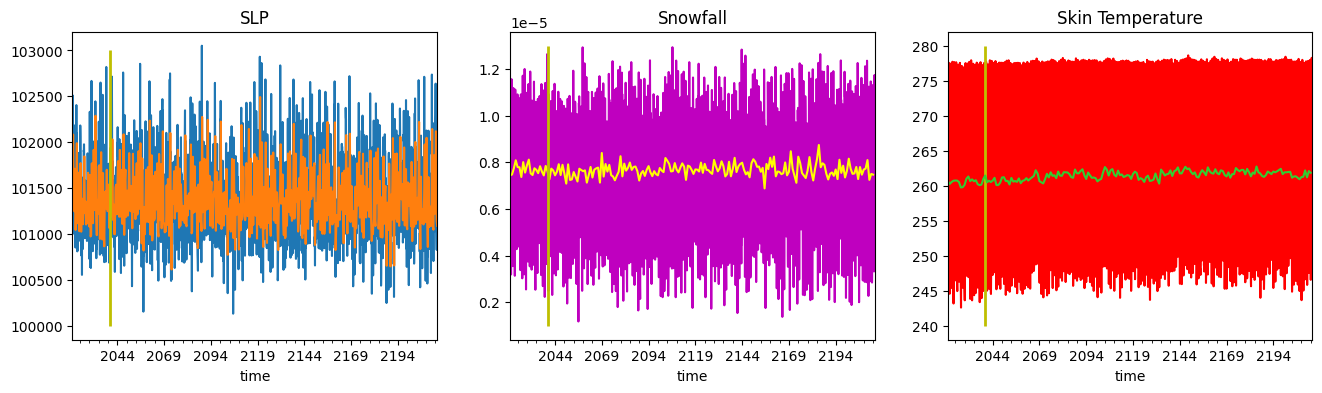

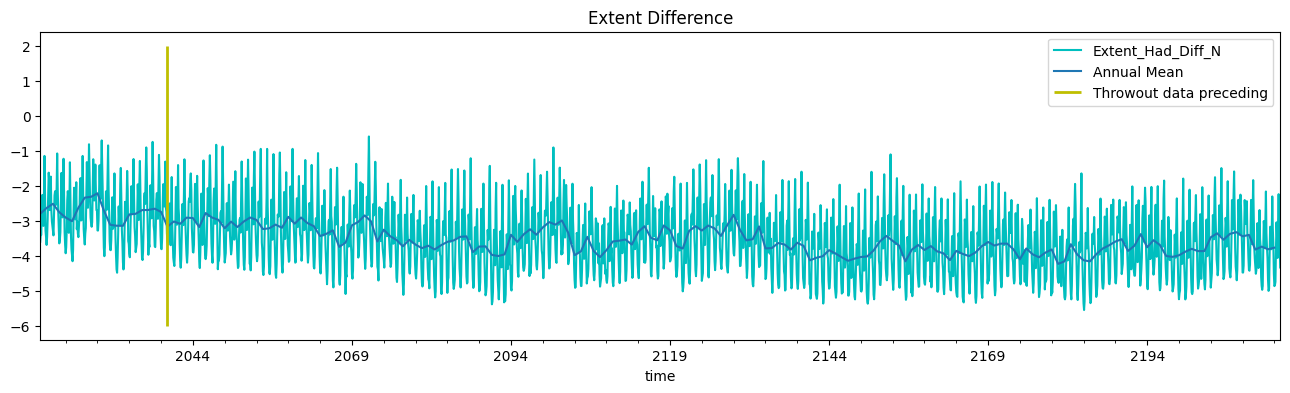

In [282]:

fig, ax = plt.subplots(1,3,figsize=(16,4))

dataset["SLP_N"].plot(ax=ax[0])
dataset["SLP_N"].groupby(pd.Grouper(freq='4M')).mean().plot(ax=ax[0],label='Annual Mean')
ax[0].vlines(dt.date(2040,1,1),1e5,1.03e5,colors='y',linewidth=2)
ax[0].set_title('SLP')

dataset["SNO_N"].plot(ax=ax[1],c='m')
dataset["SNO_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[1],label='Annual Mean',c='yellow')
ax[1].vlines(dt.date(2040,1,1),0.1e-5,1.3e-5,colors='y',linewidth=2)
ax[1].set_title('Snowfall')

dataset["TS_N"].plot(ax=ax[2],c='r')
ax[2].vlines(dt.date(2040,1,1),240,280,colors='y',linewidth=2)
dataset["TS_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax[2],label='Annual Mean',c='limegreen')
ax[2].set_title('Skin Temperature')

fig, ax = plt.subplots(1,1,figsize=(16,4))
dataset["Extent_Had_Diff_N"].plot(ax=ax,c='c')
dataset["Extent_Had_Diff_N"].groupby(pd.Grouper(freq='1Y')).mean().plot(ax=ax,label='Annual Mean')
ax.vlines(dt.date(2040,1,1),-6,2,colors='y',linewidth=2, label='Throwout data preceding')
# plt.hlines(-3, dt.date(2020,1,1), dt.date(2214,1,1))
plt.legend()
ax.set_title('Extent Difference')

In [283]:
# Plot subset of years:
# Already dropped first 5 years prior to upload, but will drop another 20 for model to reach error saturation:
dataset = dataset[dataset.index.year>=2040]
print(dataset)

                 SLP_N     SNO_N       TS_N  Extent_Had_Diff_N
time                                                          
2040-01-01  101413.445  0.000008  247.76111          -3.589388
2040-02-01  101425.410  0.000008  246.89932          -3.680192
2040-03-01  101501.280  0.000008  249.72623          -3.384821
2040-04-01  101938.055  0.000009  257.18585          -2.991412
2040-05-01  101870.980  0.000008  269.11966          -2.506895
...                ...       ...        ...                ...
2214-08-01  101027.766  0.000004  276.81607          -3.017685
2214-09-01  100945.914  0.000009  271.55286          -2.241334
2214-10-01  100826.220  0.000012  263.31000          -3.099138
2214-11-01  101244.210  0.000010  253.28346          -3.758412
2214-12-01  101192.510  0.000009  249.69000          -4.335911

[2100 rows x 4 columns]


In [287]:
# Plot new subset of data
# fig, ax = plt.subplots(1,3,figsize=(16,4))
# dataset["SLP_N"].plot(ax=ax[0])
# ax[0].set_title('SLP')

# dataset["SNO_N"].plot(ax=ax[1],c='m')
# ax[1].set_title('Snowfall')

# dataset["TS_N"].plot(ax=ax[2],c='r')
# ax[2].set_title('Skin Temperature')

# fig2, ax2 = plt.subplots(1,1,figsize=(16,4))
# dataset["Extent_Had_Diff_N"].plot(ax=ax2,c='c')
# ax2.set_title('Extent Difference')

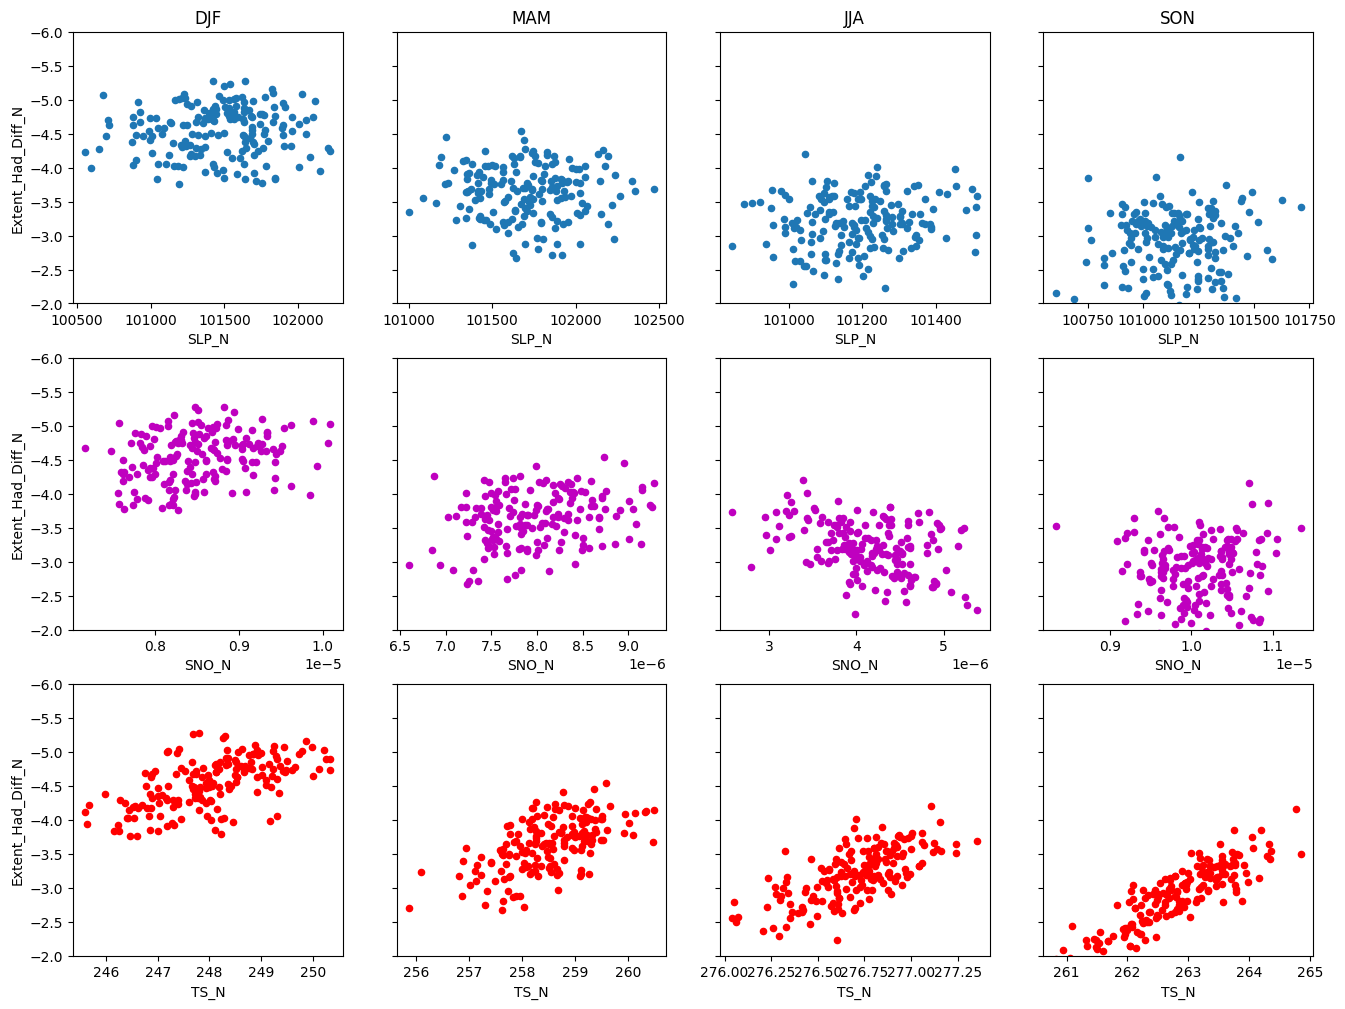

In [359]:
# Visualize seasonal data: DJF, MAM, JJA, SON

dataset_season = dataset.rolling(3,min_periods=3,center=True).mean()

seasons = ['DJF', 'MAM', 'JJA', 'SON']
month = [1,4,7,10]

fig, ax = plt.subplots(3,4,figsize=(16,12))

for i,(sea,mon) in enumerate(zip(seasons,month)):
  dataset_sea_sel = dataset_season[dataset.index.month==mon]
  dataset_sea_sel.plot.scatter("SLP_N","Extent_Had_Diff_N",ax=ax[0,i])
  dataset_sea_sel.plot.scatter("SNO_N","Extent_Had_Diff_N",ax=ax[1,i],c='m')
  dataset_sea_sel.plot.scatter("TS_N","Extent_Had_Diff_N",ax=ax[2,i],c='r')
  ax[0,i].set_title(f'{sea}')


for i in range(3):
  for j in range(4):
    ax[i,j].set_ylim([-2,-6])
    if j>0:
      ax[i,j].set_yticklabels([])
      ax[i,j].set_ylabel('')


**Part B: Train Dataset**

In [215]:
# Because time series data, train/test split by years
# 70/30 distribution
split = round((dataset.index.year[-1] - dataset.index.year[0])*0.7)
trainds = dataset[dataset.index.year<=2020+split]
testds = dataset[dataset.index.year>2020+split]
print(trainds.shape, testds.shape)
# print(trainds, testds)

(1644, 4) (696, 4)


In [217]:
# Reset index to remove time variable
trainds = trainds.reset_index(drop=True)
testds = testds.reset_index(drop=True)
print(trainds, testds)

           SLP_N     SNO_N       TS_N  Extent_Had_Diff_N
0     101268.305  0.000007  244.78757          -3.601841
1     101936.290  0.000008  247.04579          -3.394115
2     102509.090  0.000007  250.83794          -3.404107
3     102125.050  0.000008  256.32663          -2.402745
4     101764.450  0.000007  268.44006          -2.263581
...          ...       ...        ...                ...
1639  101163.555  0.000005  276.42938          -3.365638
1640  101125.680  0.000010  271.77747          -2.256704
1641  101812.630  0.000010  263.10380          -3.602277
1642  102195.400  0.000009  255.05669          -4.391604
1643  101807.400  0.000008  248.60677          -5.054690

[1644 rows x 4 columns]           SLP_N     SNO_N       TS_N  Extent_Had_Diff_N
0    101267.970  0.000009  249.55624          -4.935983
1    101306.984  0.000009  247.74092          -5.155815
2    100918.234  0.000008  250.60223          -4.984785
3    101823.050  0.000007  256.30320          -4.054658
4    101340

In [218]:
# print(trainds.shape, testds.shape)
# trainds = trainds.reset_index(drop=True).values.reshape(-1,1)
# testds = testds.reset_index(drop=True).values.reshape(-1,1)

In [219]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0,1))

# Rescale train + test
trainds_scaled = scaler.fit_transform(trainds)
testds_scaled = scaler.transform(testds)
print(testds_scaled)

[[0.38922445 0.6319059  0.1933343  0.09425935]
 [0.40258312 0.6266368  0.14294882 0.04841583]
 [0.26947235 0.6205567  0.22236649 0.08408209]
 ...
 [0.2379661  0.89866359 0.5750796  0.47731335]
 [0.38108885 0.73547858 0.29678592 0.33982903]
 [0.36338641 0.66819926 0.1970469  0.21939777]]


In [221]:
# Extract input data
input_test = trainds_scaled[:,:3]
print(input_test.shape)

(1644, 3)


In [222]:
# Extract target output
target_test = trainds_scaled[:,-1].reshape(-1,1)
print(target_test.shape)

(1644, 1)


In [226]:
# Create a Time Series Generator
data = input_test
target = target_test

n_input = 5 #Sea ice persistence of 1-5 months?
n_features = data.shape[1]

# Time series generator
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16, # you can try different batch sizes
                               shuffle=True)

In [227]:
# Double check shapes
print(data.shape, target.shape, n_features)

(1644, 3) (1644, 1) 3


In [228]:
# Double check output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.72732409 0.5267362  0.21962145]
 [0.52505393 0.62509078 0.431511  ]
 [0.46272898 0.45935152 0.72727939]
 [0.45637048 0.17429691 0.92523862]
 [0.38760144 0.11617923 0.98322001]] [0.4454168]
(16, 5, 3) (16, 1)


In [229]:
# Create Many to One LSTM
regressor = Sequential()
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=16))
regressor.add(LSTM(units=1, return_sequences=False)) # FALSE = many to one

# one neuron for output prediction
regressor.add(Dense(1))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (16, 1)                   20        
                                                                 
 dense (Dense)               (16, 1)                   2         
                                                                 
 activation (Activation)     (16, 1)                   0         
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [230]:
# Train LSTM
regressor.fit(data_gen, epochs=25)


Epoch 1/25
103/103 [==============================] - 3s 4ms/step - loss: 0.2464 - mse: 0.2464 - mae: 0.4531
Epoch 2/25
103/103 [==============================] - 0s 3ms/step - loss: 0.1474 - mse: 0.1474 - mae: 0.3300
Epoch 3/25
103/103 [==============================] - 0s 3ms/step - loss: 0.0962 - mse: 0.0962 - mae: 0.2566
Epoch 4/25
103/103 [==============================] - 0s 3ms/step - loss: 0.0630 - mse: 0.0630 - mae: 0.2035
Epoch 5/25
103/103 [==============================] - 0s 3ms/step - loss: 0.0474 - mse: 0.0474 - mae: 0.1749
Epoch 6/25
103/103 [==============================] - 0s 4ms/step - loss: 0.0392 - mse: 0.0392 - mae: 0.1608
Epoch 7/25
103/103 [==============================] - 1s 5ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1550
Epoch 8/25
103/103 [==============================] - 1s 5ms/step - loss: 0.0319 - mse: 0.0319 - mae: 0.1436
Epoch 9/25
103/103 [==============================] - 1s 5ms/step - loss: 0.0339 - mse: 0.0339 - mae: 0.1512
Epoch 10/25
103/103